# Neural Networks from scratch - a single neuron #

## To be or not to be a cat? 

We shall be addressing this crucial question in the following notebook. Going from the from the ground up, we start with a simple logistic regression classifier before building it up to eventually tackle the problem with a deep neural network.  







In [1]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage



In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', 'r')

In [3]:
list(train_dataset.keys())

['list_classes', 'train_set_x', 'train_set_y']

Loading the training and the test sets

In [6]:
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

test_dataset = h5py.File('test_catvnoncat.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

classes = np.array(test_dataset["list_classes"][:])

train_set_y_orig = train_set_y.reshape((1, train_set_y.shape[0]))
test_set_y_orig = test_set_y.reshape((1, test_set_y.shape[0]))

Load the dataset to get an idea of what the images are. Spend more time here in case you need more cat pictures in your life right now.

y = [1], it's a 'cat' picture.


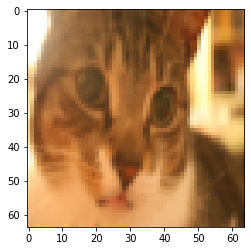

In [7]:
# Example of a picture
index = 200
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y_orig[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y_orig[:, index])].decode("utf-8") +  "' picture.")

Note that `train_set_x_orig` is a numpy array of dimension `(m_train, num_px, num_px, 3)`. It will be useful to load these as seperate variables.

In [8]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50,)


Now it is necessary to reshape the data into a form that is conventient for the algorithm. In particular, we reshape array containing the training data into an array of dimension `(num_px*num_px*3 , m)` where `m` is the number of training examples. 

In [10]:
# Reshaping both the training ad the test sets

# With the transpose, this sets the number of columns to be equal to the number of training examples.
# The '-1' indicates the remaining dimensions are automatically fit for consistency. 


train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T   
test_set_x_flatten =  test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
#print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (209,)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (50,)


It is important to standardize the dataset so that each feature is on a similar scale, analagous to making units are consistent in physics problems. 

A common way to do this is to centre the data around the mean and the variance for each feature, however things are simpler for images. Each pixel in the image correspons to a vector of three nuumber ranging from 0 to 255 indicating the red, green or blue values of each pixel. 

Dividing the dataset by 255 does as good a job as centering around the mean and variance in this case.


In [11]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

Now let's briefly review how logistic regression works. We now have a feature vector for each training example, in this case a column vector with each element corrending to the colour value of each pixel. 

For each component of this feature vector there is a corresponding weight called $w$ and a bias parameter $b$. Logistic regression is then a nonlinear function, in this case the sigmoid, of the linear input.




<img src="Logistic_Regression.png" style="width:650px;height:400px;">

For a single training example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = \sigma(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then the sum over the loss of each training example:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$


In order to do the transformation we need the sigmoid function:


In [12]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    s = 1/(1+np.exp(-z))
    
    
    return s

Initialize the weights and the bias to be all zeros:

In [13]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

Now compute the cost function (<em>forward propagation</em>) and the gradients (<em>backpropagation</em>). Note here that we have all the training examples collected into a $(n,m)$ dimensional array $X$. The activation is then also an $(n,m)$ dimensional array. 

Avoiding for loops over the training examples doesn't make a great deal of difference at this stage with just a single neuron, however when we look at a deep network it can help the algoritm run much, much faster. 

The notation here is such that $d \alpha \equiv \frac{\partial J}{\partial \alpha }$ for any parameter $\alpha$. 

In [14]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X)+b)                                    # compute activation
    cost = -(1/m)*(Y*np.log(A)+(1-Y)*np.log(1-A)).sum(axis=1)       # compute cost
    
    # BACKWARD PROPAGATION 
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*(A-Y).sum(axis=1)
   

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

Just to check we're getting something sensible out...

In [15]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = [0.00145558]
cost = 5.801545319394553


Now we can run our optimization algorithm with the cost function and gradients of the cost function that we have just derived. There are many choices available to us at this stage, but for simpliciy we shall simply use gradient descent. 

In [16]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y) 
        
        # Retrieve derivatives from grads dictionary
        dw = grads["dw"]
        db = grads["db"]
        
     
        w = w-learning_rate*dw
        b = b-learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

Now let's run our optimization algorithm on the the simple forms of $w$, $b$, $X$ and $Y$ from previously to ensure we get something sensible out. 

In [17]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = [1.92535983]
dw = [[0.67752042]
 [1.41625495]]
db = [0.2191945]


Now let's build our prediction function. With our learned parameters from the optimization algorithim, we can feed in the data $X$ to return a prediction vector $Y$ with values $1$ or $0$ depending on whether we predict it to be a cat or not a cat from the output of the sigmoid function.  

In [18]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i]>0.5:
            Y_prediction[0,i]=1
        elif A[0,i]<=0.5:
            Y_prediction[0,i]=0
        
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

With everything now in place, we can collect everyhting together into a single model function! 

This takes in our training set ` X_train`, the training labels `Y_train`, the test set `X_test`, the test labels `Y_test`, the number of iterations of the gradient descent algorithm and the learning rate and outputs the accuracy of the training set and the test set.

In [19]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0]) 

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [20]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = [1], you predicted that it is a "cat" picture.


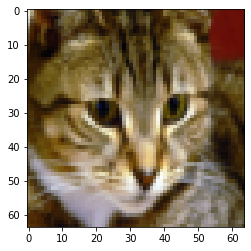

In [28]:
index = 15
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y_orig[:,index]) + ", you predicted that it is a \"" + classes[np.squeeze(test_set_y_orig[:, index])].decode("utf-8") +  "\" picture.")

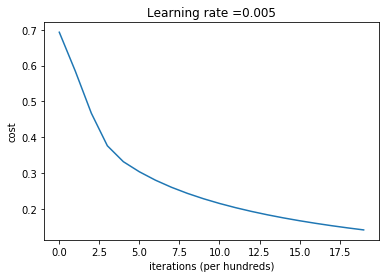

In [46]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



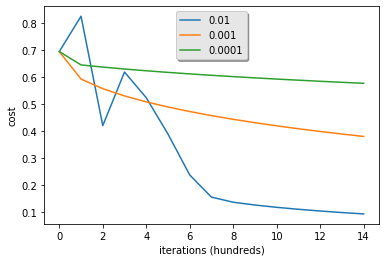

In [47]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [40]:


#### Needs updating - imread has been removed from scipy. #########

my_image = "test_cat.png"   # change this to the name of your image file 


# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

AttributeError: module 'scipy.ndimage' has no attribute 'imread'